In [12]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
BASE_PATH = "../results/all_limitless/baati"

def readAppData(path, skiprows=28):
    df = pd.read_csv(path, skiprows=skiprows, parse_dates=True)
    df["datetime"] = pd.to_datetime(df["time_h"])
    return df
    
def readResData(path):
    res = pd.read_csv(path)
    res["datetime"] = pd.to_datetime(res["time"], utc=True)
    return res
    
def readExp(expid):
    paths = glob.glob(os.path.join(expid.path, "VM_runtime_app_*.csv"))
    if len(paths) != 1:
        raise ValueError(f"Unexpeted number of performance data files {len(paths)} != 1 for " \
                f"{expid.path}")
    return readAppData(paths[0])


def dfInterval(df, tmin, tmax):
    return (tmin <= df["datetime"]) & (df["datetime"] <= tmax)

def getSplitIntervals(df):
    ais = df["ai_name"].unique()
    tss = [df.loc[df["ai_name"] == ai, "datetime"].min() for ai in ais]
    tss.append(df["datetime"].max())
    tss.sort()
    return list(zip(tss[:-1], tss[1:]))

def splitDF(df, timestampDF=None, ai_name="ai_1"):
    if timestampDF is None:
        timestampDF = df
    tss = getSplitIntervals(timestampDF)
    if ai_name is not None:
        df = df[df["ai_name"] == ai_name]
    return [df[dfInterval(df, *ts)] for ts in tss]

def getTrainingData(df, t1, t2=None, x_col="avg_cpu", x_limit=None):
    metric = "throughput_rescaled" if t1 == "linpack" else "latency_rescaled"
    avg_metric = f"avg_{metric}"
    std_metric = f"std_{metric}"
    selected_rows = (df["t1"] == t1) & (df["ai_no"] == 1)
    if t2:
        selected_rows = selected_rows & (df["t2"] == t2)
    if x_limit:
        selected_rows = selected_rows & (df[x_col] <= x_limit)
    data = df.loc[selected_rows, [x_col, avg_metric, std_metric]]
    
    xs = data.loc[selected_rows, x_col].values
    xs = xs.reshape(-1, 1)
    ys = data.loc[selected_rows, avg_metric].values
    ys_err = data.loc[selected_rows, std_metric].values
    return xs, ys, ys_err

def plotPerf(df, expid, metric_name="app_latency"):
    dfs = splitDF(df)
    fig, ax = plt.subplots()
    metric, metric_stddev = getMetrics(dfs)
    ax.errorbar(range(1, len(metric)+1), metric, yerr=metric_stddev)
    ax.set_ylabel(metric_name)
    ax.set_title(expid.expid)
    plt.show()
    
def plotRegressionLine(ax, x, y, yerr, b, expid=None, metric_name="app_latency"): 
    x = np.array(x)
    ax.errorbar(x, y,yerr, color = "m", fmt="o") 
    y_pred = b[0] + b[1]*x 
    ax.plot(x, y_pred, color = "g") 
    
def getXs(ys):
    return list(range(1, len(ys)+1))

def getRegressionCoef(reg):
    return np.array([reg.intercept_, reg.coef_[0]])

def fitRegression(exp, ys):
    xs2 = [[i] for i in getXs(ys)]
    reg = linear_model.LinearRegression()
    reg.fit(xs2, ys)
    exp.reg = reg
    exp.reg_coef = np.array([reg.intercept_, reg.coef_[0]])
    exp.error = mean_squared_error(ys, reg.predict(xs2))
    return exp.reg_coef

def analizeData(expid, df, ax, metric_name="latency"):
    print(expid.expid)
    xs, ys, ys_error = getTrainingData(df, expid.t1, expid.t2, "tasks")
    reg = linear_model.LinearRegression()
    reg.fit(xs, ys)
    #error = mean_squared_error(ys, reg.predict(xs))
    coef = np.array([reg.intercept_, reg.coef_[0]])
    plotRegressionLine(ax, xs, ys, ys_error, coef, expid, metric_name)
    return coef

def analyzeInterferenceGrid(exp_series, df):
    results = []
    n = len(exp_series.tasks)
    def formatLegend(ax, t1, t2, metric, i, j):
        if not i:
            ax.set_title(f"influence of {t2}")
        if i == n-1:
            ax.set_xlabel('number of tasks') 
        if not j:
            ax.set_ylabel(f"{t1} - {metric}") 
    fig, axes = plt.subplots(n, n, figsize=(15., 15.))
    for i, t1 in enumerate(exp_series.tasks):
        for j, t2 in enumerate(exp_series.tasks):
            ax = axes[i, j]
            metric = "throughput" if t1 == "linpack" else "latency"
            sign = -1. if metric == "throughput" else 1.
            formatLegend(ax, t1, t2, metric, i, j)
            try:
                expid = exp_series.getExperiment(t1, t2)
            except KeyError:
                print(f"WARNING: No experiment data for {t1} {t2}")
                results.append(0.)
            else:
                coefs = analizeData2(expid, df, ax, metric_name=metric)
                results.append(coefs[1] * sign)
    plt.show()
    results = np.array(results)
    results.resize([n, n])
    return np.array(results)


class ExperimentRecord:
    def __init__(self, t1, t2, path, exp_series):
        self.t1 = t1 # Task type 1
        self.t2 = t2 # Task type 2
        self.path = path
        self.base_path, self.expid = os.path.split(path)
        self.exp_series = exp_series
        self.reg = None
        self.reg_coef = [0., 0.]
        self.error = np.nan
        
class ExperimentSeries:
    def __init__(self, path, tasks, ai_role_count={}):
        self.tasks = tasks
        self.path = path
        _, self.name = os.path.split(path)
        self.type_pair_to_exp = dict()
        for t1 in tasks:
            for t2 in tasks:
                exp_paths = self.getExperimentPaths(t1, t2, path)
                if len(exp_paths) > 1:
                    raise ValueError(f"Found {len(exp_paths)}>1 experiment records for types " \
                        f"{t1} {t2} in directory {path}")
                elif len(exp_paths) == 1:
                    self.type_pair_to_exp[(t1, t2)] = ExperimentRecord(t1, t2, exp_paths[0], self)
                else:
                    print(f"Missing record for {t1} {t2}")
        print(f"Found {len(self.type_pair_to_exp)} experiment in series {self.name}")
        
        ai_type_role = dict()
        ai_type_role["redis_ycsb"] = ["ycsb", "redis"]
        ai_type_role["hadoop"] = ["hadoopmaster", "hadoopslave"]
        ai_type_role["linpack"] = ["linpack"]
        ai_type_role["wrk"] = ["wrk", "apache"]
        self.ai_type_role = ai_type_role
        
        self.ai_role_count = {}
        for _, ai_roles in self.ai_type_role.items():
            for ai_role in ai_roles:
                self.ai_role_count[ai_role] = 1
        self.ai_role_count.update(ai_role_count)
        
    @staticmethod
    def getExperimentPaths(t1, t2, base_path):
        expid = t1 if t1 == t2 else f"{t1}_{t2}"
        def matchExpidRegex(e):
            expid_regex = "[0-9]{0,4}" + expid
            i = e.split("/")[-1]
            return bool(re.fullmatch(expid_regex, i))

        pattern = os.path.join(base_path, f"*{expid}")
        expids = glob.glob(pattern)
        return [e for e in expids if matchExpidRegex(e)]
        
    def getExperiment(self, t1, t2):
        return self.type_pair_to_exp[(t1, t2)]

    def getPerfMetricsForType(self, t1):
        if t1 not in self.tasks:
            raise ValueError("Type not supported")
        if t1 == "linpack":
            return ["app_throughput"]
        return ["app_latency", "app_throughput"]

"""
Performance vs cpu
"""

"""
Functions for CPU data parsing.
"""
def getResDataPaths(expid, ai_no, role, resource):
    paths = glob.glob(os.path.join(expid.path, \
        f"resources/metric_pod_*{role}-ai-{ai_no+1}_{resource}.csv"))
    expected_count = expid.exp_series.ai_role_count[role]
    if len(paths) != expected_count:
        raise ValueError(f"Unexpected number of resources {len(paths)} != {expected_count} for " \
            f"{expid.expid} {role} {ai_no+1} {resource}")
    return paths

def toSingleRowDF(d):
    d2 = {}
    for k, v in d.items():
        d2.update({k: pd.Series(v, index=[0])})
    return pd.DataFrame(d2)

# DF: expid, t1, t2, ai_no, ai_role, tasks, avg_cpu, std_cpu, cpu_samples_count
def getResourceDatapoint(expid, ai_no, ai_role, tasks, ts, df):
    df = df.loc[dfInterval(df, *ts), ["datetime", "value"]]
    values = df["value"]
    d = {"expid": expid.expid, "t1": expid.t1, "t2": expid.t2, "ai_no": ai_no+1}
    d.update({"ai_role": ai_role, "tasks": tasks+1})
    if values.count() == 0:
        raise ValueError(f"No data samples for {expid.expid} {ai_no+1} {ai_role} {tasks}")
    d.update({"avg_cpu": values.mean(), "std_cpu": values.std(), "cpu_samples_count": values.count()})
    return toSingleRowDF(d)

def getResourceDatapointsSingleFile(expid, ai_no, ai_role, tss, df):
    results = pd.DataFrame()
    for tasks in range(ai_no, len(tss)):
        result = getResourceDatapoint(expid, ai_no, ai_role, tasks, tss[tasks], df)
        results = results.append(result, ignore_index=True)
    return results
            
def getResourceDatapoints(expid, ai_no, tss):
    results = pd.DataFrame()
    t = expid.t1 if ai_no == 0 else expid.t2
    for ai_role in expid.exp_series.ai_type_role[t]:
        paths = getResDataPaths(expid, ai_no, ai_role, "cpu")
        for path in paths:
            df = readResData(path)
            result = getResourceDatapointsSingleFile(expid, ai_no, ai_role, tss, df)
            results = results.append(result, ignore_index=True)
    return results

# cpu, cpu_aggregate, perf_cpu
def getCpuData(exp_series):
    print("Getting cpu data")
    results = pd.DataFrame()
    for t1 in exp_series.tasks:
        for t2 in exp_series.tasks:
            try:
                expid = exp_series.getExperiment(t1, t2)
            except KeyError:
                print(f"WARNING: No experiment data for {t1} {t2}")
            else:
                df = readExp(expid)
                tss = getSplitIntervals(df)
                max_ais = len(tss)
                for ai_no in range(max_ais):
                    result = getResourceDatapoints(expid, ai_no, tss)
                    results = results.append(result, ignore_index=True)
    return results

def getCpuAggregate(cpu):
    print("Aggregating cpu data")
    cpu_sum = cpu.groupby(["expid", "t1", "t2", "tasks"], as_index=False).sum()
    cpu_sum.pop("ai_no")
    return cpu_sum

def getCpuDataAll(exp_series):
    cpu = getCpuData(exp_series)
    agg = getCpuAggregate(cpu)
    return {"cpu": cpu, "cpu_agg": agg}

"""
Functions for performance data parsing.
"""
# expid, t1, t2, ai_name, tasks
def getPerfAggregate(exp_series, input_df):
    print("Aggregating perf data")
    results = pd.DataFrame()
    for expid_string in input_df["expid"].unique():
        df = input_df.loc[input_df["expid"] == expid_string, :]
        tss = getSplitIntervals(df)
        ai_count = len(tss)
        for ai_no in range(ai_count):
            ai_type = (df["t1"] if ai_no == 0 else df["t2"]).min()
            for tasks in range(ai_no, ai_count):
                ai_name = f"ai_{ai_no+1}"
                local_df = df.loc[dfInterval(df, *tss[tasks]) & (df["ai_name"] == ai_name), :]
                d = {"expid": expid_string, "ai_no": ai_no+1, "tasks": tasks+1}
                for metric in exp_series.getPerfMetricsForType(ai_type):
                    local_df = local_df.loc[local_df[metric].notna(), :]
                    if local_df.empty:
                        msg = f"Performance aggregation failed: no datapoints for " \
                            f"{expid_string} ai_no={ai_no+1} tasks={tasks} metric={metric}"
                        if ai_no == 0: # We cannot analyze data without metrics for ai 0
                            raise ValueError(msg)
                        else: # We do not care about "noise tasks" performance
                            print(f"WARNING: {msg}")
                        continue
                    perf = local_df[metric]
                    m = metric[len("app_"):]
                    d.update({f"avg_{m}": perf.mean(), f"std_{m}": perf.std()})
                    d.update({f"{m}_samples_count": perf.count()})
                results = results.append(toSingleRowDF(d), ignore_index=True)
    return results

def getPerfData(exp_series):
    print("Getting perf data")
    results = pd.DataFrame()
    for expid in exp_series.type_pair_to_exp.values():
        df = readExp(expid)
        df["expid"] = expid.expid
        df["t1"] = expid.t1
        df["t2"] = expid.t2
        results = results.append(df, ignore_index=True)
    return results
                
def getPerfDataAll(exp_series):
    perf = getPerfData(exp_series)
    agg = getPerfAggregate(exp_series, perf)
    return {"perf": perf, "perf_agg": agg}

def rescalePerfVsCpu(df):
    for t1 in df["t1"].unique():
        metric = "throughput" if t1 == "linpack" else "latency"
        avg_metric = f"avg_{metric}"
        std_metric = f"std_{metric}"
        for t2 in df.loc[df["t1"] == t1, "t2"].unique():
            selected_rows = (df["t1"] == t1) & (df["t2"] == t2) & (df["ai_no"] == 1)
            factor = df.loc[selected_rows & (df["tasks"] == 1), avg_metric].mean()
            df.loc[selected_rows, f"{avg_metric}_rescaled"] = df.loc[selected_rows, avg_metric] / factor
            df.loc[selected_rows, f"{std_metric}_rescaled"] = df.loc[selected_rows, std_metric] / factor    
    
# 2 sposoby porównania 
# Jedna krzywa dla wszystkich , ogranicz tylko do prefixu, dodaj liczbę instancji jako factor
# 4 krzywe, ogranicz tylko do prefixu, dodaj liczbę instacji jako factor
    
def getPerfVsCpu(cpu_res, perf_res):
    result = {}
    result.update(cpu_res)
    result.update(perf_res)
    result["perf_vs_cpu"] = result["cpu_agg"].merge(result["perf_agg"], on=["expid", "tasks"])
    return result
 
"""
Functions for analyzing performance vs cpu.
"""
task_to_color = {"redis_ycsb": "green", "wrk": "blue", "linpack": "yellow", "hadoop": "red"}
def printPerfVsCpu(input_df, rescale=False):
    t1s = input_df["t1"].unique()
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = [ax for axs1 in axs for ax in axs1]
    if len(t1s) == 1:
        axs = [axs]
        
    for i, t1 in enumerate(t1s):
        metric = "throughput" if t1 == "linpack" else "latency"
        avg_metric = f"avg_{metric}"
        std_metric = f"avg_{metric}"
        axs[i].set_title(f"performance of {t1}")
        selected_rows = (input_df["t1"] == t1) & (input_df["ai_no"] == 1)
        if rescale:
            factor = input_df.loc[selected_rows & (input_df["tasks"] == 1), avg_metric].mean()
            input_df.loc[selected_rows, avg_metric] = input_df.loc[selected_rows, avg_metric] / factor
            input_df.loc[selected_rows, std_metric] = input_df.loc[selected_rows, std_metric] / factor
        df = input_df.loc[selected_rows, :]
        for t2 in sorted(df["t2"].unique()):
            df2 = df.loc[df["t2"] == t2, :]
            axs[i].scatter(df2["avg_cpu"], df2[avg_metric], label=t2)
        axs[i].legend()
    plt.show()

def analyzePerfVsCpu(exp_series):
    print(f"perf vs cpu {exp_series.path}")
    cpu_res = getCpuDataAll(exp_series)
    perf_res = getPerfDataAll(exp_series)
    result = getPerfVsCpu(cpu_res, perf_res)
    rescalePerfVsCpu(result["perf_vs_cpu"])
    printPerfVsCpu(result["perf_vs_cpu"])
    return result

def getResourceSinglePod(expid, role, ts, resource="cpu", ai="ai-1"):
    tmin, tmax = ts
    paths = getResDataPaths(expid, 0, role, resource)
    res = readResData(paths[0])
    return res.loc[dfInterval(res, tmin, tmax), ["datetime", "value"]]

def getResourceLimitsRecord(ai_type, ai_role, resource, df):
    result = {"type": ai_type, "role": ai_role, "resource": resource}
    if resource == "cpu":
        unit = "m" # milicores
    elif resource == "memory":
        df["value"] = df["value"] / 2 ** 20
        unit = "Mi"
    else:
        raise ValueError(f"Unsupported resource type {resource}")
    values = df["value"]
    result.update({"avg": values.mean(), "std": values.std(), "min": values.min(), "max": values.max()})
    result.update({"unit": unit})
    return result

def getResourceLimits(exp_series):
    results = pd.DataFrame()
    for ai_type, roles in exp_series.ai_type_role.items():
        expid = exp_series.getExperiment(ai_type, ai_type)
        print(expid.expid)
        df = readExp(expid)
        tmax = df.loc[df["ai_name"] == "ai_2", "datetime"].min()
        tmin = df.loc[df["ai_name"] == "ai_1", "datetime"].min()
        ts = (tmin, tmax)
        for role in roles:
            for resource in ["cpu", "memory"]:
                df = getResourceSinglePod(expid, role, ts, resource)
                record = getResourceLimitsRecord(ai_type, role, resource, df)
                results = results.append(toSingleRowDF(record), ignore_index=True)
    return results

In [2]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/1all_limitless" 
s1 = ExperimentSeries(path, tasks)
path = "data/2more_tasks" 
s2 = ExperimentSeries(path, tasks)

Found 16 experiment in series 1all_limitless
Missing record for linpack wrk
Found 15 experiment in series 2more_tasks


# Performance vs cpu

101redis_ycsb
102redis_ycsb_wrk
172redis_ycsb_hadoop
103redis_ycsb_linpack
174wrk_redis_ycsb
106wrk
108wrk_hadoop
107wrk_linpack
178hadoop_redis_ycsb
114hadoop_wrk
116hadoop
115hadoop_linpack
109linpack_redis_ycsb
112linpack_hadoop
111linpack


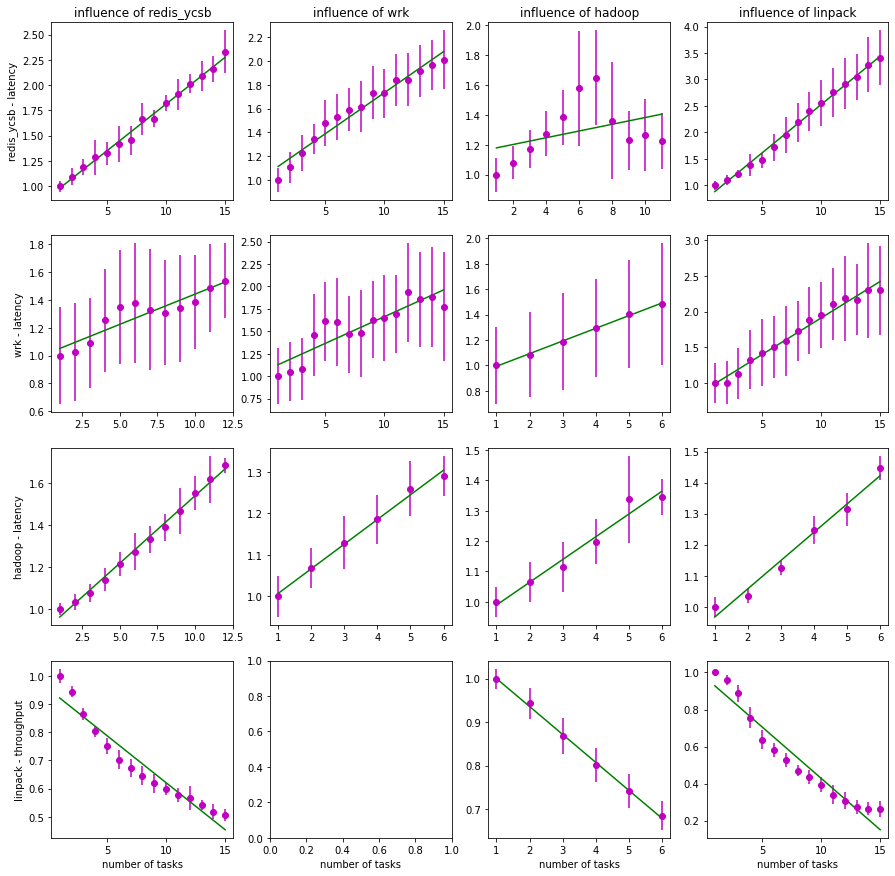

array([[0.09251838, 0.06896643, 0.02253664, 0.18303585],
       [0.04346423, 0.05950165, 0.0996998 , 0.10239049],
       [0.06407131, 0.05943509, 0.07495003, 0.0910561 ],
       [0.03340253, 0.        , 0.06426189, 0.05550344]])

In [13]:
#limits = getResourceLimits(s2)
analyzeInterferenceGrid(s2, perf_vs_cpu_res["perf_vs_cpu"])

Missing record for linpack wrk
Found 15 experiment in series 2more_tasks
perf vs cpu data/2more_tasks
Getting cpu data
Aggregating cpu data
Getting perf data
Aggregating perf data


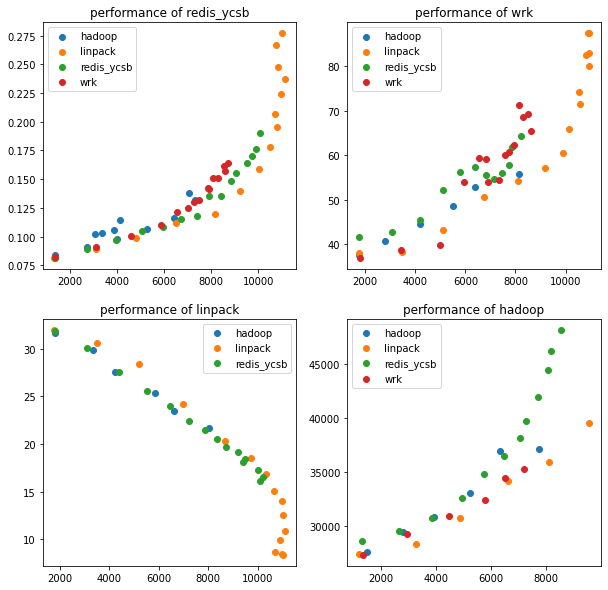

                     expid          t1          t2  tasks      avg_cpu  \
0            101redis_ycsb  redis_ycsb  redis_ycsb      1  1367.476190   
1            101redis_ycsb  redis_ycsb  redis_ycsb      2  2713.047619   
2            101redis_ycsb  redis_ycsb  redis_ycsb      2  2713.047619   
3            101redis_ycsb  redis_ycsb  redis_ycsb      3  3942.333333   
4            101redis_ycsb  redis_ycsb  redis_ycsb      3  3942.333333   
...                    ...         ...         ...    ...          ...   
1162  178hadoop_redis_ycsb      hadoop  redis_ycsb     12  8526.500000   
1163  178hadoop_redis_ycsb      hadoop  redis_ycsb     12  8526.500000   
1164  178hadoop_redis_ycsb      hadoop  redis_ycsb     12  8526.500000   
1165  178hadoop_redis_ycsb      hadoop  redis_ycsb     12  8526.500000   
1166  178hadoop_redis_ycsb      hadoop  redis_ycsb     12  8526.500000   

          std_cpu  cpu_samples_count  ai_no  avg_latency  std_latency  \
0       91.132698                 42  

In [114]:
path = "data/2more_tasks" 
s2 = ExperimentSeries(path, tasks)
perf_vs_cpu_res = analyzePerfVsCpu(s2)
print(data)

data = perf_vs_cpu_res["perf_vs_cpu"]
print("Fitting cpu per type")
results = []
for t1 in data["t1"].unique():
    xs, ys, ys_err = getTrainingData(data, t1, x_limit=10000.)
    result = fitRegression2(xs, ys)
    results.append(result)
    print(result[1:])
_, errors, counts = zip(*results)
print(np.average(errors, weights=counts))

results = []
for t1 in data["t1"].unique():
    for t2 in data.loc[data["t1"] == t1, "t2"].unique():
        xs, ys, ys_err = getTrainingData(data, t1, t2, "tasks")
        result = fitRegression2(xs, ys)
        results.append(result)
        print(result[1:])
_, errors, counts = zip(*results)
print(np.average(errors, weights=counts))
print(np.average(errors, weights=counts))

#print(perf_vs_cpu_res["perf_vs_cpu"].loc[])
#rescalePerfData(perf_vs_cpu_res["perf_vs_cpu"])
#printPerfVsCpu2(perf_vs_cpu_res["perf_vs_cpu"], rescale=False)

# Performance vs number of tasks

In [16]:
n = len(s2.tasks)
results = np.zeros((n, n))
for i, t1 in enumerate(s2.tasks):
    for j, t2 in enumerate(s2.tasks):
        try:
            exp = s2.getExperiment(t1, t2)
            results[i, j] = exp.error
        except KeyError:
            pass
print(np.mean(results))
print(results)


0.004270145520675687
[[1.23492031e-03 3.43335552e-03 2.88906822e-02 3.70629135e-03]
 [4.26605729e-03 1.62807900e-02 7.62403304e-05 3.50103248e-03]
 [2.83466673e-04 8.34588049e-05 6.20281703e-04 5.17647218e-04]
 [1.58678057e-03 0.00000000e+00 2.56035688e-05 3.81572033e-03]]


Missing record for redis_ycsb redis_ycsb
Missing record for redis_ycsb wrk
Missing record for redis_ycsb linpack
Missing record for wrk wrk
Missing record for hadoop redis_ycsb
Missing record for hadoop wrk
Missing record for linpack redis_ycsb
Missing record for linpack wrk
Missing record for linpack linpack
Found 7 experiment in series 3more_tasks_hadoop
202redis_ycsb_hadoop
304wrk_redis_ycsb
306wrk_hadoop
307wrk_linpack
230hadoop
271hadoop_linpack
214linpack_hadoop


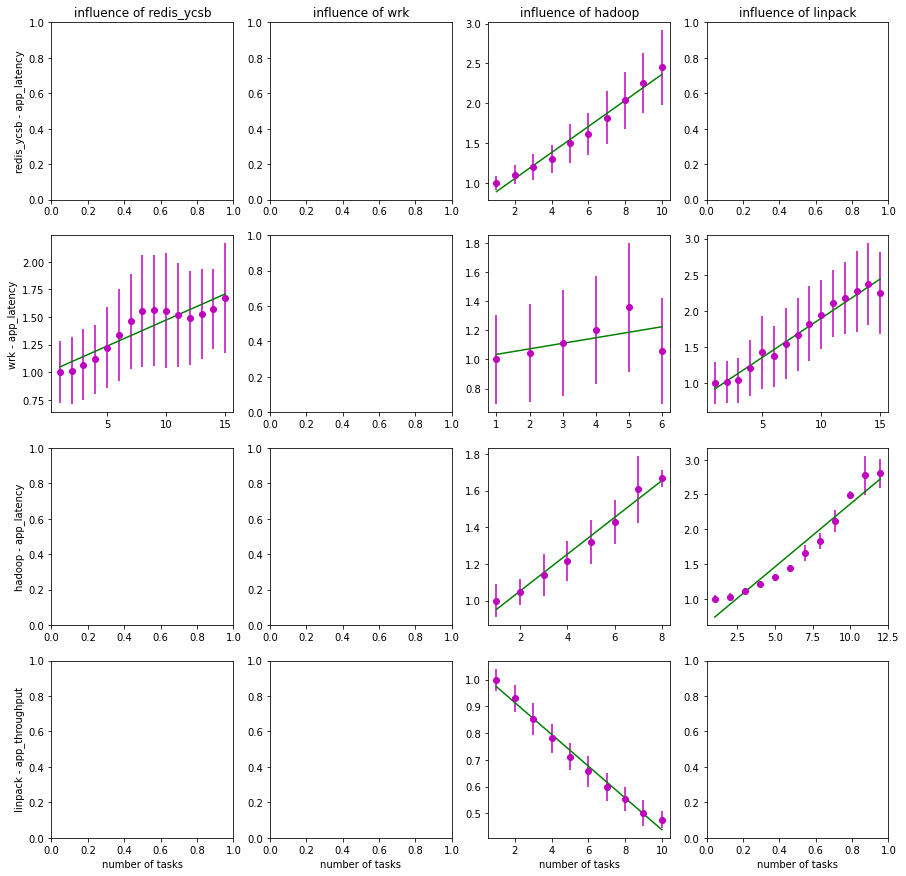

array([[0.        , 0.        , 0.16339007, 0.        ],
       [0.04721765, 0.        , 0.03799307, 0.10846218],
       [0.        , 0.        , 0.10029655, 0.18047888],
       [0.        , 0.        , 0.05947115, 0.        ]])

In [9]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/3more_tasks_hadoop" 
s3 = ExperimentSeries(path, tasks, {"hadoopslave": 2})
s3_cpu_vs_perf = analyzePerfVsCpu(s3)
analyzeInterferenceGrid(s3)

In [94]:
# hokey curve for redis_ycsb on naan

In [95]:
result = {}
for t in s2.tasks:
    expid = s2.getExperiment(t, t)
    print(expid.expid)
    result[expid.expid] = readExp(expid)
print(result.keys())

completion_time = []
for expid, df in result.items():
    print(expid)
    c = df.loc[df["ai_name"] == "ai_1" , "app_completion_time"].mean()
    completion_time.append(c)
print(completion_time)
    
#print(result.keys())
#for expid, r in result.items():
#    r2 = r.loc[r["ai_name"] == "ai_1", "app_completion_time"]
#    print(expid)
#    print(r2.describe())

101redis_ycsb
106wrk
116hadoop
111linpack
dict_keys(['101redis_ycsb', '106wrk', '116hadoop', '111linpack'])
101redis_ycsb
106wrk
116hadoop
111linpack
[1.8918032786885246, 1.4427906976744187, 44.79381443298969, 17.24773413897281]
